In [1]:
import re
from os import path
from time import time

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text,score,label
322477,1559966305008091138,desse jeito mesmo... entra lá no fundo 😈,0.267692,1
262434,1559921456351412224,hj já pode? 👀,0.063415,0
560526,1160722896198787073,eu não tenho psicológico pra isso 😍 te amo e n...,1.424024,1
158524,1559880387249274882,kkkķkkkķkkķ quer a imagem verdadeira eu mando ...,1.676596,1
713725,1160973094900707329,meus familiares arrependidos tb tão calados 🤣n...,-0.093377,-1
247871,1559916397806948354,obrigado angela 💚,0.659218,1
654384,1160893614588907520,ele nem ligou mas eu fiquei 💔,-0.121951,-1
341610,1559979680014503939,queria😔,-0.146058,-1
778096,1161082318850863107,pra você tbm 💞,0.742358,1
870648,1161317173954002944,comida foi por minha conta hj 😍,0.677937,1


## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [substring for substring in string_tratada.split() if substring not in stopwords]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join([stemmer.stem(substring) for substring in string_tratada.split()])

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

180       teriam
98      houveria
113        mesmo
162        somos
101    houvermos
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: algumas fotos que fiz no primeiro ensaio do meu studio, estou bem orgulhoso 😁

Tweet Limpo   : algumas fotos fiz primeiro ensaio studio bem orgulhoso

Tweet Stemed  : algum fot fiz prim ensai studi bem orgulh


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

,id,text,score,label,cleaned
587887,1160752171056586757,até de porra haha imagina cuspe 😋,0.633515,1,porr hah imagin cusp
900920,1161399353908629505,kit q eu uso diariamente 😂,0.220968,0,kit q uso di
837783,1161242998610497536,"😂 😂 😂 ohhh loko bate aquele desespero, pega o ...",0.662905,1,ohhh lok bat desesper peg control invé baix aí...
26535,1559750366488666114,"eu tô sentindo tanto medo, que angústia! 😓",-0.080586,-1,tô sent tant med angúst
862050,1161297669110816770,entrou varias paradinhas no meu olho nessa ven...,-0.374729,-1,entr var par olh ness ventan


# Modelo Soma das Frequencias

Este modelo é extremamente simples.

Vamos transformar o texto numa representação vetorial utilizando o somatório da frequencia que cada palavra aparece nos tweets por rótulo.

## Gerar dicionário de frequencias

Basicamente criaremos três dicionários, um positivo, um negativo e um neutro.

Cada dicionário terá a soma das vezes que a palavra aparece em seu respectivo rótulo (positivo, negativo ou neutro) em todo o dataset.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

In [11]:
# Aqui vamos criar nosso dicionário
def gerador_dicionario_tweet(tweet, dicionario):
    words = tweet.split()

    for word in words:
        dicionario[word] = dicionario.get(word, 0) + 1

In [12]:
dicionario_positivo = {}

X_train[X_train["label"] == 1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_positivo)
)

print("Chaves: {}".format(len(dicionario_positivo.keys())))

Chaves: 58366


In [13]:
dicionario_neutro = {}

X_train[X_train["label"] == 0]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_neutro)
)

print("Chaves: {}".format(len(dicionario_neutro.keys())))

Chaves: 27524


In [14]:
dicionario_negativo = {}

X_train[X_train["label"] == -1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_negativo)
)

print("Chaves: {}".format(len(dicionario_negativo.keys())))

Chaves: 32001


### Visualização dos Dicionários

In [15]:
dicionarios = pd.DataFrame([
    pd.Series(dicionario_positivo, name="positivo"),
    pd.Series(dicionario_neutro, name="neutro"),
    pd.Series(dicionario_negativo, name="negativo")
]).T

In [16]:
dicionarios.sample(10)

,positivo,neutro,negativo
squard,NaN,NaN,1.0
aliss,2.0,1.0,2.0
ágath,4.0,3.0,3.0
descansaa,1.0,NaN,NaN
aaajdkskak,1.0,NaN,NaN
elmit,2.0,NaN,NaN
delii,1.0,NaN,NaN
alema,1.0,1.0,1.0
sarmient,1.0,NaN,NaN
wors,NaN,1.0,NaN


## Gerar feature vector

Aqui nós transformaremos os textos em um vetor para podermos utilizá-los em um aprendizado supervisionado.

Nosso vetor será representado em três dimensões, uma para positivo, uma para negativo e outro para neutro.

O valor de cada dimensão é definido como o somatório das frequencias de cada palavra do tweet no dicionário da dimensão (positivo, negativo, neutro)

In [17]:
def gerar_feature_vector(
    string, dicionario_positivo, dicionario_neutro, dicionario_negativo
):
    tokens = string.split()

    # Calcula o valor de cada dimensão do vetor
    feature_positiva = sum([dicionario_positivo.get(word, 0) for word in tokens])
    feature_neutra = sum([dicionario_neutro.get(word, 0) for word in tokens])
    feature_negativa = sum([dicionario_negativo.get(word, 0) for word in tokens])

    return pd.Series(
        [feature_positiva, feature_neutra, feature_negativa],
        index=["positiva", "neutra", "negativa"],
    )

### Demonstração da Geração do Feature Vector

In [18]:
tweet = X_train["cleaned"].sample(1).values[0]
feature_vector = gerar_feature_vector(tweet, dicionario_positivo, dicionario_neutro, dicionario_negativo)

print("Tweet: {}".format(tweet))
feature_vector

Tweet: tb


positiva    1168
neutra       351
negativa     587
dtype: int64

### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [19]:
# Gerar Features Train
features_train = X_train["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(
        x, dicionario_positivo, dicionario_neutro, dicionario_negativo
    )
)
features_train["label"] = X_train["label"]

In [20]:
features_train.sample(5)

,positiva,neutra,negativa,label
236729,28567,9069,18841,-1
273545,22703,2419,9534,-1
706274,56272,9688,21409,-1
654935,40559,10654,24628,1
694271,58716,16305,30979,-1


In [21]:
X_features_train = features_train[["positiva", "neutra", "negativa"]]
X_features_train.sample(5)

,positiva,neutra,negativa
236413,12400,972,1930
576307,40164,11691,26210
806485,1215,326,999
317325,50909,7536,15999
419783,38153,8179,17579


In [22]:
y_features_train = features_train["label"]
y_features_train.sample(5)

763424   -1
849800    0
432367    1
157211    1
579705    1
Name: label, dtype: int64

### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [23]:
# Gerar Features Teste
features_test = X_test["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(
        x, dicionario_positivo, dicionario_neutro, dicionario_negativo
    )
)
features_test["label"] = X_test["label"]

In [24]:
features_test.sample(5)

,positiva,neutra,negativa,label
520993,16124,4183,9204,1
327649,68932,15261,34042,1
248137,26184,6686,11083,0
503279,13197,2991,8451,1
176009,21,14,13,1


In [25]:
X_features_test = features_test[["positiva", "neutra", "negativa"]]
X_features_test.sample(5)

,positiva,neutra,negativa
750034,975,232,514
749950,13010,4124,13602
75149,23996,1426,4883
215708,4611,1977,3566
840313,1066,276,704


In [26]:
y_features_test = features_test["label"]
y_features_test.sample(5)

78266     1
680224    1
579265    1
645332    1
115562    1
Name: label, dtype: int64

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)
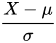

In [27]:
# Inicializar o Scaler
scaler = StandardScaler()

# Treinar o Scaler
scaler.fit(X_features_train)

StandardScaler()

In [28]:
# Transformar o conjunto de treinamento
transformed = scaler.transform(X_features_train)

# Gerar um dataframe com a saída do scaler
X_features_train_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_train_scaled.sample(5)

,positiva,neutra,negativa
235304,-0.488482,-0.518395,-0.632552
567755,0.050447,0.369139,0.166946
478700,-0.924468,-0.902337,-0.894787
264368,-0.508542,-0.554999,-0.677469
108786,-0.822332,-0.760435,-0.744918


In [29]:
transformed = scaler.transform(X_features_test)

# Gerar um dataframe com a saída do scaler
X_features_test_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_test_scaled.sample(5)

,positiva,neutra,negativa
160955,1.748723,0.650041,0.623096
197503,-0.577097,-0.374074,-0.470908
5147,-0.860357,-0.881858,-0.878797
58169,0.438745,0.681162,1.148148
178654,-0.847646,-0.815745,-0.815201


# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [30]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 3.64%


In [31]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 11.62%


In [32]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 43.03%


In [33]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 43.03%


## Logistic Regression

Referências:
- [https://en.wikipedia.org/wiki/Logistic_regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [34]:
log = LogisticRegression(random_state=42)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [35]:
params = {
    "C": [
        0.47,
        0.53,
        0.59,
        0.61,
        0.67,
        0.71,
        0.73,
        0.79,
        0.83,
        0.89,
        0.97,
        1,
        2,
        3,
        5,
        7,
        9,
        11,
        13,
        17,
        19,
        21,
    ],
    "tol": [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
}

clf = RandomizedSearchCV(log, params, scoring="f1_weighted", n_jobs=-1, random_state=42)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 52.12%


In [36]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [37]:
print("Score Baseline : {:.2f}%".format(baseline_score*100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_*100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score-clf.best_score_)*100))

Score Baseline : 43.03%
Score Modelo   : 52.12%
Diferença      : 9.10%


### Performance no Conjunto de Treino

In [38]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 52.12%


### Curva de Aprendizado

In [39]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

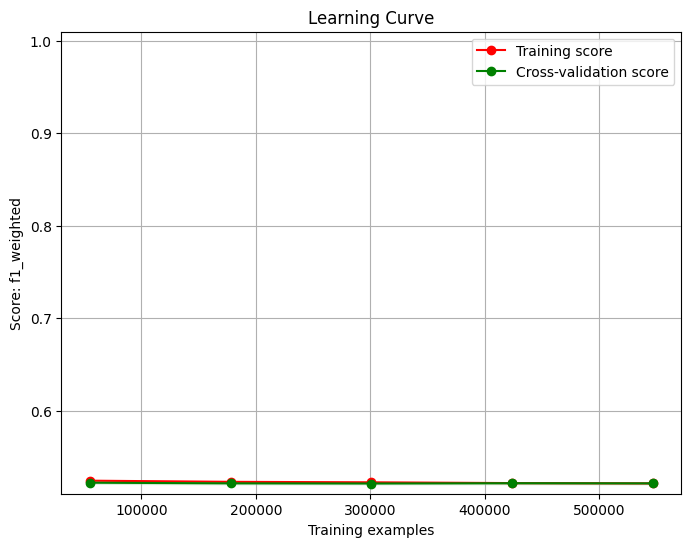

In [40]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Random Forest

Referências:
- [https://en.wikipedia.org/wiki/Random_forest](https://en.wikipedia.org/wiki/Random_forest)
- [https://scikit-learn.org/stable/modules/ensemble.html#forest](https://scikit-learn.org/stable/modules/ensemble.html#forest)

In [41]:
rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

In [42]:
s1 = time()
scores = cross_val_score(
    rf, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
rf_score = scores.mean()

s2 = time()
print("Elapsed Time: ", int(s2 - s1), "seconds")

print("F-Score: {:.2f}%".format(rf_score * 100))

Elapsed Time:  52 seconds
F-Score: 58.87%


In [43]:
rf.fit(X_features_train_scaled, y_features_train)

RandomForestClassifier(min_samples_leaf=2, n_jobs=-1, random_state=42)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search]

In [44]:
# Codigo
# rf = RandomForestClassifier(random_state = 42, n_jobs = -1)
# params = {
#    'n_estimators': [100,200,300],
#    'min_samples_split': [2,3,4,5],
#    'min_samples_leaf': [1,2,3,4],
# }

# clf = RandomizedSearchCV(rf, params, scoring='f1_weighted', random_state=42)
# clf.fit(X_features_train_scaled, y_features_train)

# print("Best F-Score: {:.2f}%".format(clf.best_score_*100))

In [45]:
# clf.best_params_
print({"n_estimators": 100, "min_samples_split": 2, "min_samples_leaf": 2})

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2}


In [46]:
# rf = clf.best_estimator_

#### Comparação com Métrica base

In [47]:
print("Score Baseline : {:.2f}%".format(baseline_score*100))
print("Score Modelo   : {:.2f}%".format(rf_score*100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score-rf_score)*100))

Score Baseline : 43.03%
Score Modelo   : 58.87%
Diferença      : 15.85%


### Performance no Conjunto de Treino

In [48]:
y_pred = rf.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 89.98%


### Curva de Aprendizado

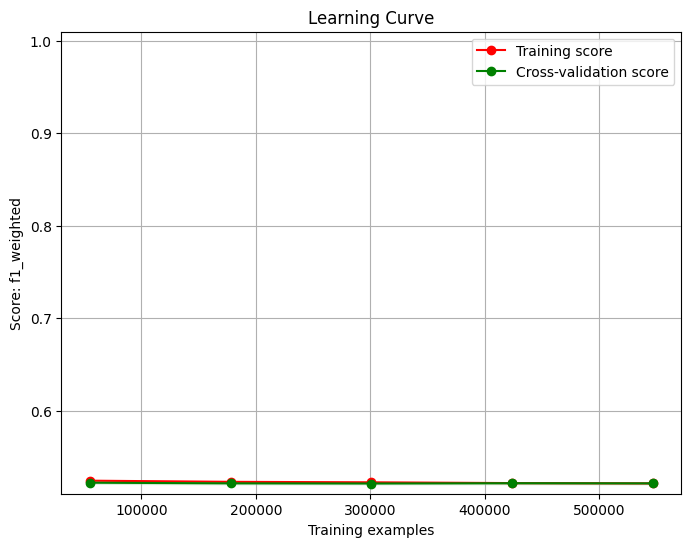

In [49]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Validação em conjunto de Teste

In [50]:
y_pred = rf.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 58.61%


### Preditos Positivos

In [51]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [52]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['eu não tenho irmã 😭', 'sobrancelha tá horrivel😐',
       'pelo amor de deus eu não sei o que tá acontecendo cmg 😕',
       'eu até faço a publi😫',
       '😭😭 só gostam de gente magra na internet 😭',
       'é mais barato você mesmo customizar, fora isso é sorte achar😪',
       'nossa que sonho 😔',
       'as vezes minha vontade é de sumir 😤 só assim as pessoas irão dar o devido valor, ou dar graças a deus .',
       'hahshahhahshaa 😭', 'askaksksksk😔😔\U0001faf6🏻'], dtype=object)

#### Falso Positivo -> Neutro

In [53]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['tu tá tirando fácil uns reais livre por mês! brabo 🔥',
       'ainda sobre o final de semana.. 😅🤧',
       'você é uma das minas mais gostosas que eu já vi, morro de vontade de comprar teu pack no snap, pena que namoro 😂 —…',
       'eu b sei 😰', 'eu dou te os meus kg a mais 😂',
       '😂 agora estão usando até a vovozinha.',
       'pelo menos assim ja temos companhia 😂', 'bom dia ☕ boa semana',
       'resolvi postar minha primeira dancinha no tiktok 😂',
       'olha eu e a 😂'], dtype=object)

#### Verdadeiro Positivo

In [54]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['você i eu 😚',
       'se cuida aí e fica com deus meu amor. que ele te proteja de tudo e todos. te amo do tamanho do mundo 💙',
       'olá , adoraria escutar "cansar de dançar” da juliette, em sua programação! obrigada (o)! londrina 🎶💃',
       'obg mo 💙',
       'haverá dias bons, haverá dias ruins, mas haverá deus em tds! bom dia ❤',
       'sempre splendida 🤗😘',
       'mostre de qual estado vcs são e mande a listas por estado tbm pf 🙏👈🇧🇷😎',
       '‼️pré venda abre meio dia!🚀🚀🚀 🎉carnarildy • a / • rio centro - rj 💡o ingresso com desconto é o que tem a tarja verde! 🎟️código de desconto: burla 👆o link c/desconto é esse mas as vendas só abrem meio dia, favorita aqui pra n perder!',
       'tbm te amo 💘', 'vão conhecer minha pior versão 😎'], dtype=object)

### Preditos Negativos

In [55]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [56]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['só queria que a puma tivesse esse compromisso comigo 😌😏',
       'que sdd que eu tava de ir lá 😄',
       'esse churros ali da esquina tá caro p crlh, tnc 😈',
       'me da tanta paz el tema sunset lover no se porque 😌',
       'poxa obg 💙 fiquei tímida', 'eu sou doida todo dia mano 👍',
       'eu quero um romance assim 🥰💪🏻🐀🐓', 'fumando outro 🎈',
       'ne? e é só no sábado a noite essa putaria. assisto fofocaçizando e sempre começa e acaba na hora certinha. 😝',
       'queria tanto um quarteirão do mc 😋'], dtype=object)

#### Falso Negativo -> Neutro

In [57]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['é cúmulo do despautério 😹',
       'fudeu 😳 tenho uma insônia doida n quero nem saber o q tenho feito acordada nos sonhos alheios',
       'parece que alguém levou um baile e não foi o puto 👀',
       'necessites ajuda?😳',
       'nem to chateado com a derrota, agora e so ganhar mais seguidas e ta perdoado 😅',
       'eu olhando os nudes no celular da falsiane 😱 como é que o márcio deu confirmação p/ essa embuste …',
       'eu preciso sair 😳',
       'convenhamos q uma criança de anos nunca viu o botafogo ganhar um título... 👀',
       'hj volto pro curso de inglês. tinha até esquecido! 😂',
       'tentando não pensar muito no jogo para não ficar nervoso😂🥵🥵'],
      dtype=object)

#### Verdadeiro Negativo

In [58]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(['dias pro meu aniversário 😣',
       'minha cabeça tá explodindo, só queria conseguir dormir 😫',
       'eu só queria aquele abraço gostoso dnv 😪',
       'passa tanta coisa na minha cabeça que eu fico sem entender 😫',
       'meu tio com esses roncos atrapalha o sono dos outros 😡',
       'da nem pra acreditar, logo você irmão 😭', 'naaaoo 😭',
       'quero ver a viagem mas n tem no globoplay 😔',
       'eu queria tá como 😭😭😭', 'volto ou nao volto a vender doces??? 😫😫'],
      dtype=object)

### Preditos Neutros

In [59]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [60]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['👏🏻👏🏻👍👍.. não sabia thiago ! pensava que os motores a pistão fossem maiores e mais pesados ..por serem antigos',
       'que vergonha alheia 🙈', 'se for vc eu quero🙈',
       'que pena que pena, que querer não é poder se fosse, se fosse só ia dar eu e você..🎶',
       'vamos os dois 🙏',
       'chega a madrugada, o telefone toca mas eu não atendo, bate em minha porta só que eu tenho medo de me arrepender já não sei direito mais quem é você 🎶🎶',
       'houve a notícia no morro que a polícia chegou malandro que é malandro se esconde em baixo da figueira perguntou seu marabô onde mora exu caveira 🎶🚬🎲🎩',
       'kkk meu braço cansa de copia as coisa na escola mas não cansa quando to laçando kkk😝',
       'é logo ali 😘', 'era só uma praia hj 😏'], dtype=object)

#### Falso Neutro -> Negativo

In [61]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['ela escreve a anos, mas não sabe escrever há anos 😔',
       'alguém faz 😭',
       'ficar sem notícias não poder fazer nada e muito ruim 😫',
       'ele quer q eu cuide? 😔',
       'kkk fui seco achando que tinha um canal mesmo. mas será que eu sou um qualquer um daí??? 😔',
       'tinha anos que eu não passava barbeador na axila (só uso máquina). tinha me esquecido como essa porra coça 😑',
       'geral na praia e eu? 😭', 'o meu tbm esta assim 😒',
       'última temporada 😔', 'duro mesmo é morar km longe deles 😩'],
      dtype=object)

#### Verdadeiro Neutro

In [62]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['pique o travis 🙅🏻🔥', 'ontas bebe 👀',
       'quase kg 😮 baratinho! nutriwhey pouch . kg morango, integralmedica 🔥r$ , à vista 🛒',
       'eu já li muito sobre energias eu que estas a falar 😅',
       '📣 ™ 🆙 go book 🆙 💯 🏛', '👀 cadê ❓❓❓',
       'eu montei outra playlist só de funk pesado cara e tá muito foda 👀',
       'pior que não. acho que era uma contribuição pro churrasco mesmo 😂',
       'nem me digas nada 😅',
       'meu série s tá com meu sobrinho...e ele praticamente só joga warzone! ontem ele veio perguntar se eu ia comprar o cód 😂! eu praticamente só estou jogando play por causa dele...não sei o q faço 🤦🏻\u200d♀️'],
      dtype=object)